In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('actitracker_raw2.txt')
dataset = dataset.replace(";","",regex=True)#.replace(';',',')

In [5]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

TypeError: must be str, not int

In [6]:
dataset

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.198203,0.804142,0.50395286
1,33,Jogging,49106062271000,0.635039,0.594170,0.95342433
2,33,Jogging,49106112167000,0.619130,0.537639,-0.08172209
3,33,Jogging,49106222305000,-0.186271,1.666240,3.0237172
4,33,Jogging,49106332290000,-0.269795,0.719346,7.205164
5,33,Jogging,49106442306000,0.104071,-1.444986,-6.510526
6,33,Jogging,49106542312000,-0.186271,0.491202,5.706926
7,33,Jogging,49106652389000,-0.170362,0.991906,7.0553403
8,33,Jogging,49106762313000,-1.327754,0.616378,5.134871
9,33,Jogging,49106872299000,0.042423,-0.871599,1.6480621


TypeError: unsupported operand type(s) for -: 'float' and 'str'

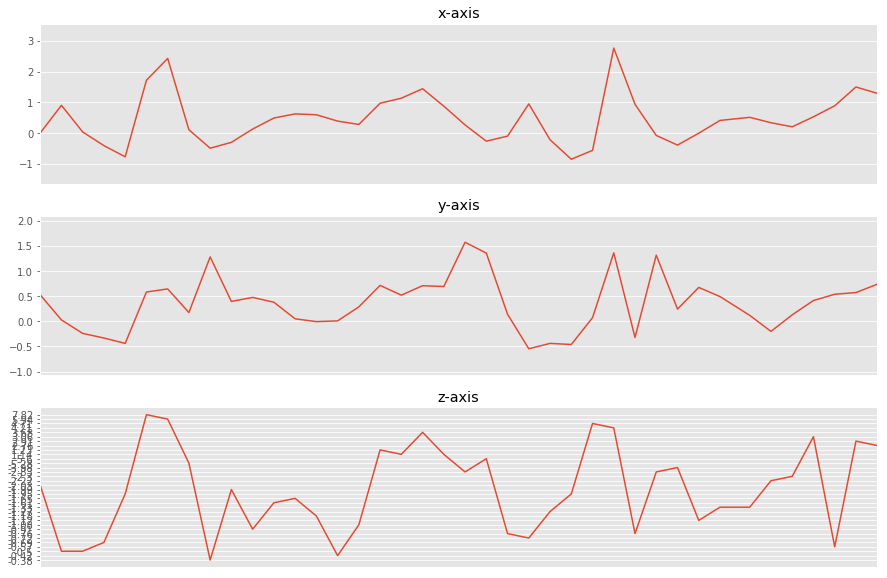

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [7]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [8]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [29]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 200

total_batches = train_x.shape[0] // batch_size

In [30]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [31]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
train_x.shape

(17152, 1, 90, 3)

In [33]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  362.583  Training Accuracy:  0.0402285
Epoch:  1  Training Loss:  350.113  Training Accuracy:  0.0404618
Epoch:  2  Training Loss:  327.752  Training Accuracy:  0.0413363
Epoch:  3  Training Loss:  310.012  Training Accuracy:  0.0444263
Epoch:  4  Training Loss:  295.755  Training Accuracy:  0.0503731
Epoch:  5  Training Loss:  285.349  Training Accuracy:  0.056903
Epoch:  6  Training Loss:  276.388  Training Accuracy:  0.0614506
Epoch:  7  Training Loss:  268.185  Training Accuracy:  0.0656483
Epoch:  8  Training Loss:  261.591  Training Accuracy:  0.0687966
Epoch:  9  Training Loss:  256.177  Training Accuracy:  0.0730527
Epoch:  10  Training Loss:  250.486  Training Accuracy:  0.0796409
Epoch:  11  Training Loss:  245.803  Training Accuracy:  0.0866954
Epoch:  12  Training Loss:  242.079  Training Accuracy:  0.0932836
Epoch:  13  Training Loss:  237.89  Training Accuracy:  0.0998717
Epoch:  14  Training Loss:  234.16  Training Accuracy:  0.108151
Epoch:  1

Epoch:  125  Training Loss:  51.2802  Training Accuracy:  0.545184
Epoch:  126  Training Loss:  50.6173  Training Accuracy:  0.546875
Epoch:  127  Training Loss:  49.9668  Training Accuracy:  0.548332
Epoch:  128  Training Loss:  49.3606  Training Accuracy:  0.549673
Epoch:  129  Training Loss:  48.7454  Training Accuracy:  0.551772
Epoch:  130  Training Loss:  48.1504  Training Accuracy:  0.554338
Epoch:  131  Training Loss:  47.5793  Training Accuracy:  0.555853
Epoch:  132  Training Loss:  47.0548  Training Accuracy:  0.558768
Epoch:  133  Training Loss:  46.5198  Training Accuracy:  0.560634
Epoch:  134  Training Loss:  45.9708  Training Accuracy:  0.562208
Epoch:  135  Training Loss:  45.4361  Training Accuracy:  0.564482
Epoch:  136  Training Loss:  44.888  Training Accuracy:  0.566348
Epoch:  137  Training Loss:  44.3834  Training Accuracy:  0.568213
Epoch:  138  Training Loss:  43.888  Training Accuracy:  0.569379
Epoch:  139  Training Loss:  43.4  Training Accuracy:  0.570487


In [35]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  414.358  Training Accuracy:  0.0404034
Epoch:  1  Training Loss:  339.82  Training Accuracy:  0.0419193
Epoch:  2  Training Loss:  318.763  Training Accuracy:  0.0439016
Epoch:  3  Training Loss:  304.583  Training Accuracy:  0.0529967
Epoch:  4  Training Loss:  295.077  Training Accuracy:  0.0570196
Epoch:  5  Training Loss:  288.822  Training Accuracy:  0.0613923
Epoch:  6  Training Loss:  283.434  Training Accuracy:  0.0645989
Epoch:  7  Training Loss:  278.24  Training Accuracy:  0.0677472
Epoch:  8  Training Loss:  272.86  Training Accuracy:  0.0721782
Epoch:  9  Training Loss:  268.1  Training Accuracy:  0.0774254
Epoch:  10  Training Loss:  264.53  Training Accuracy:  0.0819146
Epoch:  11  Training Loss:  261.466  Training Accuracy:  0.0866954
Epoch:  12  Training Loss:  259.32  Training Accuracy:  0.0920592
Epoch:  13  Training Loss:  256.504  Training Accuracy:  0.0966068
Epoch:  14  Training Loss:  254.046  Training Accuracy:  0.101504
Epoch:  15  T

Epoch:  125  Training Loss:  66.3068  Training Accuracy:  0.532941
Epoch:  126  Training Loss:  65.4645  Training Accuracy:  0.534515
Epoch:  127  Training Loss:  64.6741  Training Accuracy:  0.536672
Epoch:  128  Training Loss:  63.9058  Training Accuracy:  0.538188
Epoch:  129  Training Loss:  63.0818  Training Accuracy:  0.540228
Epoch:  130  Training Loss:  62.3642  Training Accuracy:  0.54256
Epoch:  131  Training Loss:  61.5894  Training Accuracy:  0.544426
Epoch:  132  Training Loss:  60.8073  Training Accuracy:  0.546233
Epoch:  133  Training Loss:  60.118  Training Accuracy:  0.547808
Epoch:  134  Training Loss:  59.4309  Training Accuracy:  0.549615
Epoch:  135  Training Loss:  58.7796  Training Accuracy:  0.550723
Epoch:  136  Training Loss:  58.0839  Training Accuracy:  0.552297
Epoch:  137  Training Loss:  57.4277  Training Accuracy:  0.553696
Epoch:  138  Training Loss:  56.8009  Training Accuracy:  0.554979
Epoch:  139  Training Loss:  56.1514  Training Accuracy:  0.5571

Epoch:  248  Training Loss:  20.8721  Training Accuracy:  0.713328
Epoch:  249  Training Loss:  20.725  Training Accuracy:  0.714319
Epoch:  250  Training Loss:  20.5541  Training Accuracy:  0.715718
Epoch:  251  Training Loss:  20.411  Training Accuracy:  0.716767
Epoch:  252  Training Loss:  20.2499  Training Accuracy:  0.718167
Epoch:  253  Training Loss:  20.1009  Training Accuracy:  0.719449
Epoch:  254  Training Loss:  19.9361  Training Accuracy:  0.72044
Epoch:  255  Training Loss:  19.7835  Training Accuracy:  0.721606
Epoch:  256  Training Loss:  19.6221  Training Accuracy:  0.723006
Epoch:  257  Training Loss:  19.4711  Training Accuracy:  0.723939
Epoch:  258  Training Loss:  19.3055  Training Accuracy:  0.725338
Epoch:  259  Training Loss:  19.1536  Training Accuracy:  0.726387
Epoch:  260  Training Loss:  18.9854  Training Accuracy:  0.727612
Epoch:  261  Training Loss:  18.8446  Training Accuracy:  0.728719
Epoch:  262  Training Loss:  18.6847  Training Accuracy:  0.72959

In [36]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 400

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  438.936  Training Accuracy:  0.0411031
Epoch:  1  Training Loss:  380.767  Training Accuracy:  0.0458256
Epoch:  2  Training Loss:  359.341  Training Accuracy:  0.050548
Epoch:  3  Training Loss:  343.18  Training Accuracy:  0.0541045
Epoch:  4  Training Loss:  329.443  Training Accuracy:  0.0578941
Epoch:  5  Training Loss:  318.669  Training Accuracy:  0.0611591
Epoch:  6  Training Loss:  308.909  Training Accuracy:  0.0649487
Epoch:  7  Training Loss:  300.199  Training Accuracy:  0.0693214
Epoch:  8  Training Loss:  293.185  Training Accuracy:  0.0735774
Epoch:  9  Training Loss:  287.75  Training Accuracy:  0.0805154
Epoch:  10  Training Loss:  282.464  Training Accuracy:  0.0870452
Epoch:  11  Training Loss:  277.017  Training Accuracy:  0.0942164
Epoch:  12  Training Loss:  271.936  Training Accuracy:  0.102262
Epoch:  13  Training Loss:  267.43  Training Accuracy:  0.109667
Epoch:  14  Training Loss:  263.632  Training Accuracy:  0.117945
Epoch:  15  

Epoch:  125  Training Loss:  57.8152  Training Accuracy:  0.546816
Epoch:  126  Training Loss:  57.1008  Training Accuracy:  0.548216
Epoch:  127  Training Loss:  56.5327  Training Accuracy:  0.549557
Epoch:  128  Training Loss:  55.862  Training Accuracy:  0.551481
Epoch:  129  Training Loss:  55.2446  Training Accuracy:  0.553113
Epoch:  130  Training Loss:  54.6495  Training Accuracy:  0.55492
Epoch:  131  Training Loss:  54.0582  Training Accuracy:  0.556495
Epoch:  132  Training Loss:  53.5022  Training Accuracy:  0.558768
Epoch:  133  Training Loss:  52.9387  Training Accuracy:  0.560051
Epoch:  134  Training Loss:  52.3584  Training Accuracy:  0.5618
Epoch:  135  Training Loss:  51.843  Training Accuracy:  0.563549
Epoch:  136  Training Loss:  51.3006  Training Accuracy:  0.565007
Epoch:  137  Training Loss:  50.7852  Training Accuracy:  0.567047
Epoch:  138  Training Loss:  50.2993  Training Accuracy:  0.568913
Epoch:  139  Training Loss:  49.7704  Training Accuracy:  0.570779


Epoch:  248  Training Loss:  21.2356  Training Accuracy:  0.726154
Epoch:  249  Training Loss:  20.9918  Training Accuracy:  0.72732
Epoch:  250  Training Loss:  20.9672  Training Accuracy:  0.728486
Epoch:  251  Training Loss:  20.6822  Training Accuracy:  0.72971
Epoch:  252  Training Loss:  20.6143  Training Accuracy:  0.730352
Epoch:  253  Training Loss:  20.4079  Training Accuracy:  0.731401
Epoch:  254  Training Loss:  20.3354  Training Accuracy:  0.732159
Epoch:  255  Training Loss:  20.0977  Training Accuracy:  0.732917
Epoch:  256  Training Loss:  20.0912  Training Accuracy:  0.73385
Epoch:  257  Training Loss:  19.8188  Training Accuracy:  0.735307
Epoch:  258  Training Loss:  19.7299  Training Accuracy:  0.736007
Epoch:  259  Training Loss:  19.5586  Training Accuracy:  0.73729
Epoch:  260  Training Loss:  19.4751  Training Accuracy:  0.737931
Epoch:  261  Training Loss:  19.2934  Training Accuracy:  0.739389
Epoch:  262  Training Loss:  19.1781  Training Accuracy:  0.740846

Epoch:  371  Training Loss:  8.91835  Training Accuracy:  0.831389
Epoch:  372  Training Loss:  8.8213  Training Accuracy:  0.831739
Epoch:  373  Training Loss:  8.84662  Training Accuracy:  0.832847
Epoch:  374  Training Loss:  8.71482  Training Accuracy:  0.832964
Epoch:  375  Training Loss:  8.65797  Training Accuracy:  0.834071
Epoch:  376  Training Loss:  8.64192  Training Accuracy:  0.834654
Epoch:  377  Training Loss:  8.56216  Training Accuracy:  0.835529
Epoch:  378  Training Loss:  8.50612  Training Accuracy:  0.836112
Epoch:  379  Training Loss:  8.50434  Training Accuracy:  0.837103
Epoch:  380  Training Loss:  8.39182  Training Accuracy:  0.837628
Epoch:  381  Training Loss:  8.39933  Training Accuracy:  0.838561
Epoch:  382  Training Loss:  8.28692  Training Accuracy:  0.839202
Epoch:  383  Training Loss:  8.29493  Training Accuracy:  0.840018
Epoch:  384  Training Loss:  8.1932  Training Accuracy:  0.840601
Epoch:  385  Training Loss:  8.19577  Training Accuracy:  0.8411

In [37]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  422.684  Training Accuracy:  0.0405201
Epoch:  1  Training Loss:  335.716  Training Accuracy:  0.0416861
Epoch:  2  Training Loss:  316.765  Training Accuracy:  0.048041
Epoch:  3  Training Loss:  305.135  Training Accuracy:  0.0535215
Epoch:  4  Training Loss:  295.663  Training Accuracy:  0.0592351
Epoch:  5  Training Loss:  288.212  Training Accuracy:  0.0645406
Epoch:  6  Training Loss:  282.65  Training Accuracy:  0.0685051
Epoch:  7  Training Loss:  278.443  Training Accuracy:  0.0729361
Epoch:  8  Training Loss:  274.774  Training Accuracy:  0.0781833
Epoch:  9  Training Loss:  271.798  Training Accuracy:  0.083722
Epoch:  10  Training Loss:  269.515  Training Accuracy:  0.0897854
Epoch:  11  Training Loss:  266.724  Training Accuracy:  0.0957906
Epoch:  12  Training Loss:  264.855  Training Accuracy:  0.101737
Epoch:  13  Training Loss:  263.528  Training Accuracy:  0.108267
Epoch:  14  Training Loss:  262.271  Training Accuracy:  0.11573
Epoch:  15  

Epoch:  125  Training Loss:  84.3085  Training Accuracy:  0.509153
Epoch:  126  Training Loss:  83.3965  Training Accuracy:  0.511194
Epoch:  127  Training Loss:  82.4176  Training Accuracy:  0.514109
Epoch:  128  Training Loss:  81.5466  Training Accuracy:  0.515858
Epoch:  129  Training Loss:  80.6723  Training Accuracy:  0.517782
Epoch:  130  Training Loss:  79.773  Training Accuracy:  0.519881
Epoch:  131  Training Loss:  78.949  Training Accuracy:  0.521863
Epoch:  132  Training Loss:  78.0403  Training Accuracy:  0.52437
Epoch:  133  Training Loss:  77.2361  Training Accuracy:  0.526352
Epoch:  134  Training Loss:  76.3925  Training Accuracy:  0.528626
Epoch:  135  Training Loss:  75.6079  Training Accuracy:  0.530259
Epoch:  136  Training Loss:  74.8124  Training Accuracy:  0.531949
Epoch:  137  Training Loss:  74.1214  Training Accuracy:  0.533932
Epoch:  138  Training Loss:  73.3326  Training Accuracy:  0.535273
Epoch:  139  Training Loss:  72.5563  Training Accuracy:  0.53725

Epoch:  248  Training Loss:  30.7935  Training Accuracy:  0.693447
Epoch:  249  Training Loss:  30.5471  Training Accuracy:  0.694263
Epoch:  250  Training Loss:  30.3547  Training Accuracy:  0.69537
Epoch:  251  Training Loss:  30.1175  Training Accuracy:  0.696945
Epoch:  252  Training Loss:  29.9223  Training Accuracy:  0.698344
Epoch:  253  Training Loss:  29.7062  Training Accuracy:  0.700326
Epoch:  254  Training Loss:  29.4977  Training Accuracy:  0.701317
Epoch:  255  Training Loss:  29.2865  Training Accuracy:  0.702367
Epoch:  256  Training Loss:  29.09  Training Accuracy:  0.703708
Epoch:  257  Training Loss:  28.8891  Training Accuracy:  0.704407
Epoch:  258  Training Loss:  28.6926  Training Accuracy:  0.705748
Epoch:  259  Training Loss:  28.484  Training Accuracy:  0.707089
Epoch:  260  Training Loss:  28.2774  Training Accuracy:  0.70843
Epoch:  261  Training Loss:  28.0927  Training Accuracy:  0.709829
Epoch:  262  Training Loss:  27.8879  Training Accuracy:  0.711287


Epoch:  371  Training Loss:  12.7881  Training Accuracy:  0.819204
Epoch:  372  Training Loss:  12.7032  Training Accuracy:  0.820021
Epoch:  373  Training Loss:  12.609  Training Accuracy:  0.82037
Epoch:  374  Training Loss:  12.5421  Training Accuracy:  0.820895
Epoch:  375  Training Loss:  12.4415  Training Accuracy:  0.821595
Epoch:  376  Training Loss:  12.3595  Training Accuracy:  0.822003
Epoch:  377  Training Loss:  12.2801  Training Accuracy:  0.822819
Epoch:  378  Training Loss:  12.1937  Training Accuracy:  0.823285
Epoch:  379  Training Loss:  12.1091  Training Accuracy:  0.82416
Epoch:  380  Training Loss:  12.021  Training Accuracy:  0.824568
Epoch:  381  Training Loss:  11.9402  Training Accuracy:  0.825209
Epoch:  382  Training Loss:  11.8576  Training Accuracy:  0.825618
Epoch:  383  Training Loss:  11.7699  Training Accuracy:  0.826434
Epoch:  384  Training Loss:  11.6955  Training Accuracy:  0.827192
Epoch:  385  Training Loss:  11.6082  Training Accuracy:  0.827833

Epoch:  494  Training Loss:  6.1348  Training Accuracy:  0.885319
Epoch:  495  Training Loss:  6.1057  Training Accuracy:  0.885436
Epoch:  496  Training Loss:  6.07767  Training Accuracy:  0.885785
Epoch:  497  Training Loss:  6.04575  Training Accuracy:  0.886019
Epoch:  498  Training Loss:  6.02342  Training Accuracy:  0.886427
Epoch:  499  Training Loss:  5.99372  Training Accuracy:  0.886602
Testing Accuracy: 0.804303


In [38]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 200

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  1060.45  Training Accuracy:  0.0394706
Epoch:  1  Training Loss:  904.633  Training Accuracy:  0.044368
Epoch:  2  Training Loss:  851.505  Training Accuracy:  0.0660564
Epoch:  3  Training Loss:  809.492  Training Accuracy:  0.0745686
Epoch:  4  Training Loss:  771.055  Training Accuracy:  0.0789995
Epoch:  5  Training Loss:  741.02  Training Accuracy:  0.0812733
Epoch:  6  Training Loss:  712.902  Training Accuracy:  0.0847715
Epoch:  7  Training Loss:  688.299  Training Accuracy:  0.0891441
Epoch:  8  Training Loss:  669.18  Training Accuracy:  0.0949743
Epoch:  9  Training Loss:  650.825  Training Accuracy:  0.100805
Epoch:  10  Training Loss:  633.515  Training Accuracy:  0.106926
Epoch:  11  Training Loss:  619.908  Training Accuracy:  0.115497
Epoch:  12  Training Loss:  606.665  Training Accuracy:  0.124242
Epoch:  13  Training Loss:  594.166  Training Accuracy:  0.133279
Epoch:  14  Training Loss:  583.069  Training Accuracy:  0.14045
Epoch:  15  Tra

Epoch:  125  Training Loss:  110.0  Training Accuracy:  0.58757
Epoch:  126  Training Loss:  108.542  Training Accuracy:  0.589435
Epoch:  127  Training Loss:  106.938  Training Accuracy:  0.591068
Epoch:  128  Training Loss:  105.525  Training Accuracy:  0.592467
Epoch:  129  Training Loss:  103.982  Training Accuracy:  0.594391
Epoch:  130  Training Loss:  102.632  Training Accuracy:  0.596024
Epoch:  131  Training Loss:  101.251  Training Accuracy:  0.598181
Epoch:  132  Training Loss:  99.9132  Training Accuracy:  0.600046
Epoch:  133  Training Loss:  98.5575  Training Accuracy:  0.601562
Epoch:  134  Training Loss:  97.323  Training Accuracy:  0.603486
Epoch:  135  Training Loss:  95.9231  Training Accuracy:  0.605585
Epoch:  136  Training Loss:  94.8297  Training Accuracy:  0.607392
Epoch:  137  Training Loss:  93.449  Training Accuracy:  0.609258
Epoch:  138  Training Loss:  92.3779  Training Accuracy:  0.610774
Epoch:  139  Training Loss:  91.0743  Training Accuracy:  0.61264
E

In [39]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  1473.84  Training Accuracy:  0.046875
Epoch:  1  Training Loss:  927.084  Training Accuracy:  0.0577192
Epoch:  2  Training Loss:  822.954  Training Accuracy:  0.0638993
Epoch:  3  Training Loss:  768.102  Training Accuracy:  0.0739855
Epoch:  4  Training Loss:  731.537  Training Accuracy:  0.0846548
Epoch:  5  Training Loss:  704.461  Training Accuracy:  0.0961987
Epoch:  6  Training Loss:  685.269  Training Accuracy:  0.107568
Epoch:  7  Training Loss:  669.92  Training Accuracy:  0.118179
Epoch:  8  Training Loss:  655.565  Training Accuracy:  0.128498
Epoch:  9  Training Loss:  643.199  Training Accuracy:  0.137127
Epoch:  10  Training Loss:  634.062  Training Accuracy:  0.14459
Epoch:  11  Training Loss:  626.792  Training Accuracy:  0.151236
Epoch:  12  Training Loss:  618.269  Training Accuracy:  0.157066
Epoch:  13  Training Loss:  608.746  Training Accuracy:  0.163013
Epoch:  14  Training Loss:  602.366  Training Accuracy:  0.169426
Epoch:  15  Train

Epoch:  125  Training Loss:  90.2571  Training Accuracy:  0.618237
Epoch:  126  Training Loss:  89.0056  Training Accuracy:  0.620627
Epoch:  127  Training Loss:  87.8746  Training Accuracy:  0.622668
Epoch:  128  Training Loss:  86.6863  Training Accuracy:  0.624766
Epoch:  129  Training Loss:  85.5018  Training Accuracy:  0.626457
Epoch:  130  Training Loss:  84.4116  Training Accuracy:  0.628498
Epoch:  131  Training Loss:  83.3428  Training Accuracy:  0.629606
Epoch:  132  Training Loss:  82.1511  Training Accuracy:  0.632171
Epoch:  133  Training Loss:  81.1873  Training Accuracy:  0.633512
Epoch:  134  Training Loss:  80.0539  Training Accuracy:  0.635261
Epoch:  135  Training Loss:  79.1385  Training Accuracy:  0.637243
Epoch:  136  Training Loss:  78.0107  Training Accuracy:  0.639109
Epoch:  137  Training Loss:  77.1621  Training Accuracy:  0.641441
Epoch:  138  Training Loss:  76.0815  Training Accuracy:  0.643073
Epoch:  139  Training Loss:  75.2452  Training Accuracy:  0.64

Epoch:  248  Training Loss:  32.8085  Training Accuracy:  0.774545
Epoch:  249  Training Loss:  32.6124  Training Accuracy:  0.775361
Epoch:  250  Training Loss:  32.4074  Training Accuracy:  0.776294
Epoch:  251  Training Loss:  32.2217  Training Accuracy:  0.777635
Epoch:  252  Training Loss:  32.0106  Training Accuracy:  0.777751
Epoch:  253  Training Loss:  31.8201  Training Accuracy:  0.778509
Epoch:  254  Training Loss:  31.7051  Training Accuracy:  0.779209
Epoch:  255  Training Loss:  31.487  Training Accuracy:  0.780025
Epoch:  256  Training Loss:  31.2764  Training Accuracy:  0.780783
Epoch:  257  Training Loss:  31.0984  Training Accuracy:  0.781483
Epoch:  258  Training Loss:  30.8807  Training Accuracy:  0.782474
Epoch:  259  Training Loss:  30.6819  Training Accuracy:  0.783174
Epoch:  260  Training Loss:  30.515  Training Accuracy:  0.784223
Epoch:  261  Training Loss:  30.3311  Training Accuracy:  0.785039
Epoch:  262  Training Loss:  30.1428  Training Accuracy:  0.7855

In [40]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 400

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  736.479  Training Accuracy:  0.0504314
Epoch:  1  Training Loss:  751.757  Training Accuracy:  0.0562617
Epoch:  2  Training Loss:  722.908  Training Accuracy:  0.0606343
Epoch:  3  Training Loss:  690.925  Training Accuracy:  0.0652985
Epoch:  4  Training Loss:  660.04  Training Accuracy:  0.0717701
Epoch:  5  Training Loss:  643.927  Training Accuracy:  0.0795242
Epoch:  6  Training Loss:  628.171  Training Accuracy:  0.0886194
Epoch:  7  Training Loss:  612.925  Training Accuracy:  0.0957323
Epoch:  8  Training Loss:  603.697  Training Accuracy:  0.104011
Epoch:  9  Training Loss:  592.597  Training Accuracy:  0.114389
Epoch:  10  Training Loss:  581.341  Training Accuracy:  0.124067
Epoch:  11  Training Loss:  571.553  Training Accuracy:  0.133162
Epoch:  12  Training Loss:  562.884  Training Accuracy:  0.140217
Epoch:  13  Training Loss:  556.527  Training Accuracy:  0.148088
Epoch:  14  Training Loss:  549.618  Training Accuracy:  0.155492
Epoch:  15  T

Epoch:  125  Training Loss:  88.6392  Training Accuracy:  0.608675
Epoch:  126  Training Loss:  87.414  Training Accuracy:  0.610541
Epoch:  127  Training Loss:  86.1898  Training Accuracy:  0.612173
Epoch:  128  Training Loss:  84.9296  Training Accuracy:  0.614097
Epoch:  129  Training Loss:  83.7392  Training Accuracy:  0.615671
Epoch:  130  Training Loss:  82.7213  Training Accuracy:  0.61812
Epoch:  131  Training Loss:  81.4955  Training Accuracy:  0.619986
Epoch:  132  Training Loss:  80.3266  Training Accuracy:  0.621443
Epoch:  133  Training Loss:  79.2622  Training Accuracy:  0.623542
Epoch:  134  Training Loss:  78.2297  Training Accuracy:  0.624767
Epoch:  135  Training Loss:  77.1068  Training Accuracy:  0.626865
Epoch:  136  Training Loss:  76.1786  Training Accuracy:  0.628731
Epoch:  137  Training Loss:  75.0837  Training Accuracy:  0.630597
Epoch:  138  Training Loss:  74.1627  Training Accuracy:  0.632637
Epoch:  139  Training Loss:  73.2109  Training Accuracy:  0.6348

Epoch:  248  Training Loss:  27.2196  Training Accuracy:  0.771397
Epoch:  249  Training Loss:  27.0932  Training Accuracy:  0.772446
Epoch:  250  Training Loss:  26.8858  Training Accuracy:  0.773262
Epoch:  251  Training Loss:  26.7046  Training Accuracy:  0.773962
Epoch:  252  Training Loss:  26.5294  Training Accuracy:  0.774836
Epoch:  253  Training Loss:  26.3686  Training Accuracy:  0.776177
Epoch:  254  Training Loss:  26.2173  Training Accuracy:  0.776935
Epoch:  255  Training Loss:  26.0449  Training Accuracy:  0.77816
Epoch:  256  Training Loss:  25.8954  Training Accuracy:  0.778859
Epoch:  257  Training Loss:  25.7493  Training Accuracy:  0.779559
Epoch:  258  Training Loss:  25.5792  Training Accuracy:  0.780433
Epoch:  259  Training Loss:  25.3914  Training Accuracy:  0.780958
Epoch:  260  Training Loss:  25.2668  Training Accuracy:  0.781366
Epoch:  261  Training Loss:  25.0649  Training Accuracy:  0.782066
Epoch:  262  Training Loss:  24.9602  Training Accuracy:  0.783

Epoch:  371  Training Loss:  12.6394  Training Accuracy:  0.853078
Epoch:  372  Training Loss:  12.5174  Training Accuracy:  0.853369
Epoch:  373  Training Loss:  12.4423  Training Accuracy:  0.853777
Epoch:  374  Training Loss:  12.3966  Training Accuracy:  0.854361
Epoch:  375  Training Loss:  12.2871  Training Accuracy:  0.855002
Epoch:  376  Training Loss:  12.2461  Training Accuracy:  0.855585
Epoch:  377  Training Loss:  12.1405  Training Accuracy:  0.855818
Epoch:  378  Training Loss:  12.1005  Training Accuracy:  0.856226
Epoch:  379  Training Loss:  11.9924  Training Accuracy:  0.856693
Epoch:  380  Training Loss:  11.9417  Training Accuracy:  0.857217
Epoch:  381  Training Loss:  11.8629  Training Accuracy:  0.857742
Epoch:  382  Training Loss:  11.792  Training Accuracy:  0.8585
Epoch:  383  Training Loss:  11.7246  Training Accuracy:  0.858792
Epoch:  384  Training Loss:  11.6053  Training Accuracy:  0.859433
Epoch:  385  Training Loss:  11.5691  Training Accuracy:  0.86001

In [41]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  978.022  Training Accuracy:  0.0415112
Epoch:  1  Training Loss:  863.345  Training Accuracy:  0.0532882
Epoch:  2  Training Loss:  825.14  Training Accuracy:  0.0595266
Epoch:  3  Training Loss:  792.727  Training Accuracy:  0.0706623
Epoch:  4  Training Loss:  767.979  Training Accuracy:  0.079291
Epoch:  5  Training Loss:  742.533  Training Accuracy:  0.0861707
Epoch:  6  Training Loss:  722.482  Training Accuracy:  0.0922341
Epoch:  7  Training Loss:  703.429  Training Accuracy:  0.100688
Epoch:  8  Training Loss:  686.753  Training Accuracy:  0.108326
Epoch:  9  Training Loss:  673.105  Training Accuracy:  0.115905
Epoch:  10  Training Loss:  659.723  Training Accuracy:  0.125292
Epoch:  11  Training Loss:  648.27  Training Accuracy:  0.134153
Epoch:  12  Training Loss:  638.029  Training Accuracy:  0.14319
Epoch:  13  Training Loss:  629.302  Training Accuracy:  0.150128
Epoch:  14  Training Loss:  618.384  Training Accuracy:  0.157183
Epoch:  15  Train

Epoch:  125  Training Loss:  150.215  Training Accuracy:  0.589319
Epoch:  126  Training Loss:  147.947  Training Accuracy:  0.591942
Epoch:  127  Training Loss:  145.988  Training Accuracy:  0.593575
Epoch:  128  Training Loss:  143.851  Training Accuracy:  0.595499
Epoch:  129  Training Loss:  141.91  Training Accuracy:  0.597889
Epoch:  130  Training Loss:  139.926  Training Accuracy:  0.59923
Epoch:  131  Training Loss:  138.009  Training Accuracy:  0.601212
Epoch:  132  Training Loss:  136.102  Training Accuracy:  0.602553
Epoch:  133  Training Loss:  134.312  Training Accuracy:  0.604361
Epoch:  134  Training Loss:  132.525  Training Accuracy:  0.605935
Epoch:  135  Training Loss:  130.666  Training Accuracy:  0.607684
Epoch:  136  Training Loss:  128.988  Training Accuracy:  0.609142
Epoch:  137  Training Loss:  127.151  Training Accuracy:  0.611066
Epoch:  138  Training Loss:  125.41  Training Accuracy:  0.613106
Epoch:  139  Training Loss:  123.721  Training Accuracy:  0.61503

Epoch:  248  Training Loss:  35.6168  Training Accuracy:  0.758395
Epoch:  249  Training Loss:  35.2832  Training Accuracy:  0.759095
Epoch:  250  Training Loss:  34.9805  Training Accuracy:  0.760319
Epoch:  251  Training Loss:  34.6236  Training Accuracy:  0.761252
Epoch:  252  Training Loss:  34.379  Training Accuracy:  0.762185
Epoch:  253  Training Loss:  34.0925  Training Accuracy:  0.763176
Epoch:  254  Training Loss:  33.8145  Training Accuracy:  0.763701
Epoch:  255  Training Loss:  33.5256  Training Accuracy:  0.764692
Epoch:  256  Training Loss:  33.2529  Training Accuracy:  0.765566
Epoch:  257  Training Loss:  32.9601  Training Accuracy:  0.766324
Epoch:  258  Training Loss:  32.6998  Training Accuracy:  0.767082
Epoch:  259  Training Loss:  32.4422  Training Accuracy:  0.767957
Epoch:  260  Training Loss:  32.2066  Training Accuracy:  0.768948
Epoch:  261  Training Loss:  31.9254  Training Accuracy:  0.769881
Epoch:  262  Training Loss:  31.6642  Training Accuracy:  0.771

Epoch:  371  Training Loss:  15.195  Training Accuracy:  0.849055
Epoch:  372  Training Loss:  15.137  Training Accuracy:  0.849463
Epoch:  373  Training Loss:  15.0828  Training Accuracy:  0.849638
Epoch:  374  Training Loss:  14.974  Training Accuracy:  0.850046
Epoch:  375  Training Loss:  14.9144  Training Accuracy:  0.850279
Epoch:  376  Training Loss:  14.8206  Training Accuracy:  0.851037
Epoch:  377  Training Loss:  14.7289  Training Accuracy:  0.851445
Epoch:  378  Training Loss:  14.6708  Training Accuracy:  0.851679
Epoch:  379  Training Loss:  14.5895  Training Accuracy:  0.852436
Epoch:  380  Training Loss:  14.4969  Training Accuracy:  0.852961
Epoch:  381  Training Loss:  14.4638  Training Accuracy:  0.853486
Epoch:  382  Training Loss:  14.3378  Training Accuracy:  0.853719
Epoch:  383  Training Loss:  14.2779  Training Accuracy:  0.854127
Epoch:  384  Training Loss:  14.2275  Training Accuracy:  0.854361
Epoch:  385  Training Loss:  14.1134  Training Accuracy:  0.85465

Epoch:  494  Training Loss:  8.1023  Training Accuracy:  0.895347
Epoch:  495  Training Loss:  8.05872  Training Accuracy:  0.895638
Epoch:  496  Training Loss:  8.05541  Training Accuracy:  0.895872
Epoch:  497  Training Loss:  7.98783  Training Accuracy:  0.896338
Epoch:  498  Training Loss:  7.99114  Training Accuracy:  0.896688
Epoch:  499  Training Loss:  7.90448  Training Accuracy:  0.897096
Testing Accuracy: 0.821128


In [42]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 600

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  1001.5  Training Accuracy:  0.0407533
Epoch:  1  Training Loss:  845.854  Training Accuracy:  0.0493237
Epoch:  2  Training Loss:  783.433  Training Accuracy:  0.0610424
Epoch:  3  Training Loss:  738.805  Training Accuracy:  0.0757346
Epoch:  4  Training Loss:  705.491  Training Accuracy:  0.0900187
Epoch:  5  Training Loss:  676.033  Training Accuracy:  0.102146
Epoch:  6  Training Loss:  652.869  Training Accuracy:  0.115497
Epoch:  7  Training Loss:  632.897  Training Accuracy:  0.127449
Epoch:  8  Training Loss:  614.153  Training Accuracy:  0.138701
Epoch:  9  Training Loss:  597.98  Training Accuracy:  0.148088
Epoch:  10  Training Loss:  585.743  Training Accuracy:  0.155667
Epoch:  11  Training Loss:  573.884  Training Accuracy:  0.163538
Epoch:  12  Training Loss:  562.375  Training Accuracy:  0.172225
Epoch:  13  Training Loss:  548.984  Training Accuracy:  0.181262
Epoch:  14  Training Loss:  537.846  Training Accuracy:  0.189832
Epoch:  15  Train

Epoch:  125  Training Loss:  96.3983  Training Accuracy:  0.594624
Epoch:  126  Training Loss:  95.011  Training Accuracy:  0.596024
Epoch:  127  Training Loss:  93.5461  Training Accuracy:  0.598064
Epoch:  128  Training Loss:  92.1109  Training Accuracy:  0.599755
Epoch:  129  Training Loss:  90.7894  Training Accuracy:  0.601096
Epoch:  130  Training Loss:  89.3865  Training Accuracy:  0.603253
Epoch:  131  Training Loss:  88.032  Training Accuracy:  0.604536
Epoch:  132  Training Loss:  86.7453  Training Accuracy:  0.60611
Epoch:  133  Training Loss:  85.4386  Training Accuracy:  0.607975
Epoch:  134  Training Loss:  84.1248  Training Accuracy:  0.610308
Epoch:  135  Training Loss:  82.9125  Training Accuracy:  0.612931
Epoch:  136  Training Loss:  81.6274  Training Accuracy:  0.615263
Epoch:  137  Training Loss:  80.4539  Training Accuracy:  0.617071
Epoch:  138  Training Loss:  79.2198  Training Accuracy:  0.61812
Epoch:  139  Training Loss:  78.1319  Training Accuracy:  0.619694

Epoch:  248  Training Loss:  26.7685  Training Accuracy:  0.753439
Epoch:  249  Training Loss:  26.5618  Training Accuracy:  0.754197
Epoch:  250  Training Loss:  26.4406  Training Accuracy:  0.75478
Epoch:  251  Training Loss:  26.2609  Training Accuracy:  0.755655
Epoch:  252  Training Loss:  26.0793  Training Accuracy:  0.757054
Epoch:  253  Training Loss:  25.9291  Training Accuracy:  0.757812
Epoch:  254  Training Loss:  25.7624  Training Accuracy:  0.758337
Epoch:  255  Training Loss:  25.584  Training Accuracy:  0.759153
Epoch:  256  Training Loss:  25.4623  Training Accuracy:  0.760203
Epoch:  257  Training Loss:  25.3218  Training Accuracy:  0.761427
Epoch:  258  Training Loss:  25.137  Training Accuracy:  0.762127
Epoch:  259  Training Loss:  25.0008  Training Accuracy:  0.763001
Epoch:  260  Training Loss:  24.8799  Training Accuracy:  0.763876
Epoch:  261  Training Loss:  24.7583  Training Accuracy:  0.76475
Epoch:  262  Training Loss:  24.6431  Training Accuracy:  0.765974

Epoch:  371  Training Loss:  13.7193  Training Accuracy:  0.842642
Epoch:  372  Training Loss:  13.6789  Training Accuracy:  0.843458
Epoch:  373  Training Loss:  13.6076  Training Accuracy:  0.843866
Epoch:  374  Training Loss:  13.5355  Training Accuracy:  0.844974
Epoch:  375  Training Loss:  13.479  Training Accuracy:  0.845615
Epoch:  376  Training Loss:  13.4183  Training Accuracy:  0.846548
Epoch:  377  Training Loss:  13.3343  Training Accuracy:  0.847014
Epoch:  378  Training Loss:  13.3065  Training Accuracy:  0.847248
Epoch:  379  Training Loss:  13.1789  Training Accuracy:  0.847423
Epoch:  380  Training Loss:  13.1513  Training Accuracy:  0.848122
Epoch:  381  Training Loss:  13.0761  Training Accuracy:  0.848822
Epoch:  382  Training Loss:  13.0166  Training Accuracy:  0.849055
Epoch:  383  Training Loss:  12.9464  Training Accuracy:  0.849463
Epoch:  384  Training Loss:  12.8911  Training Accuracy:  0.849813
Epoch:  385  Training Loss:  12.8073  Training Accuracy:  0.850

Epoch:  494  Training Loss:  8.07328  Training Accuracy:  0.890041
Epoch:  495  Training Loss:  8.04691  Training Accuracy:  0.89045
Epoch:  496  Training Loss:  7.99835  Training Accuracy:  0.890625
Epoch:  497  Training Loss:  7.98153  Training Accuracy:  0.891033
Epoch:  498  Training Loss:  7.94197  Training Accuracy:  0.891266
Epoch:  499  Training Loss:  7.89997  Training Accuracy:  0.891441
Epoch:  500  Training Loss:  7.86962  Training Accuracy:  0.891674
Epoch:  501  Training Loss:  7.8395  Training Accuracy:  0.891965
Epoch:  502  Training Loss:  7.8131  Training Accuracy:  0.892315
Epoch:  503  Training Loss:  7.78531  Training Accuracy:  0.892607
Epoch:  504  Training Loss:  7.74958  Training Accuracy:  0.893015
Epoch:  505  Training Loss:  7.73275  Training Accuracy:  0.893365
Epoch:  506  Training Loss:  7.70393  Training Accuracy:  0.893598
Epoch:  507  Training Loss:  7.68625  Training Accuracy:  0.893598
Epoch:  508  Training Loss:  7.646  Training Accuracy:  0.894123


In [43]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  406.32  Training Accuracy:  0.0409865
Epoch:  1  Training Loss:  351.361  Training Accuracy:  0.0421525
Epoch:  2  Training Loss:  324.969  Training Accuracy:  0.0430854
Epoch:  3  Training Loss:  308.678  Training Accuracy:  0.0486241
Epoch:  4  Training Loss:  296.975  Training Accuracy:  0.0571945
Epoch:  5  Training Loss:  288.892  Training Accuracy:  0.0624417
Epoch:  6  Training Loss:  282.659  Training Accuracy:  0.0680387
Epoch:  7  Training Loss:  277.205  Training Accuracy:  0.0735774
Epoch:  8  Training Loss:  272.355  Training Accuracy:  0.0780084
Epoch:  9  Training Loss:  268.178  Training Accuracy:  0.0811567
Epoch:  10  Training Loss:  264.245  Training Accuracy:  0.0858792
Epoch:  11  Training Loss:  260.81  Training Accuracy:  0.0915345
Epoch:  12  Training Loss:  257.501  Training Accuracy:  0.0979478
Epoch:  13  Training Loss:  254.102  Training Accuracy:  0.104594
Epoch:  14  Training Loss:  250.879  Training Accuracy:  0.111765
Epoch:  1

Epoch:  125  Training Loss:  55.086  Training Accuracy:  0.530783
Epoch:  126  Training Loss:  54.4521  Training Accuracy:  0.532124
Epoch:  127  Training Loss:  53.7637  Training Accuracy:  0.533873
Epoch:  128  Training Loss:  53.1214  Training Accuracy:  0.535448
Epoch:  129  Training Loss:  52.4772  Training Accuracy:  0.536847
Epoch:  130  Training Loss:  51.8728  Training Accuracy:  0.538363
Epoch:  131  Training Loss:  51.2478  Training Accuracy:  0.540228
Epoch:  132  Training Loss:  50.6164  Training Accuracy:  0.541394
Epoch:  133  Training Loss:  50.0509  Training Accuracy:  0.542794
Epoch:  134  Training Loss:  49.431  Training Accuracy:  0.544601
Epoch:  135  Training Loss:  48.903  Training Accuracy:  0.546233
Epoch:  136  Training Loss:  48.3299  Training Accuracy:  0.548041
Epoch:  137  Training Loss:  47.7674  Training Accuracy:  0.550373
Epoch:  138  Training Loss:  47.2029  Training Accuracy:  0.552472
Epoch:  139  Training Loss:  46.7154  Training Accuracy:  0.55398

Epoch:  248  Training Loss:  20.5028  Training Accuracy:  0.714085
Epoch:  249  Training Loss:  20.3803  Training Accuracy:  0.714785
Epoch:  250  Training Loss:  20.2621  Training Accuracy:  0.715893
Epoch:  251  Training Loss:  20.1589  Training Accuracy:  0.716884
Epoch:  252  Training Loss:  20.0295  Training Accuracy:  0.718342
Epoch:  253  Training Loss:  19.9296  Training Accuracy:  0.719916
Epoch:  254  Training Loss:  19.7958  Training Accuracy:  0.721315
Epoch:  255  Training Loss:  19.7052  Training Accuracy:  0.722772
Epoch:  256  Training Loss:  19.6015  Training Accuracy:  0.724347
Epoch:  257  Training Loss:  19.4857  Training Accuracy:  0.725221
Epoch:  258  Training Loss:  19.3742  Training Accuracy:  0.726737
Epoch:  259  Training Loss:  19.2583  Training Accuracy:  0.727786
Epoch:  260  Training Loss:  19.1557  Training Accuracy:  0.729186
Epoch:  261  Training Loss:  19.0511  Training Accuracy:  0.730527
Epoch:  262  Training Loss:  18.9283  Training Accuracy:  0.73

Epoch:  371  Training Loss:  9.66998  Training Accuracy:  0.831798
Epoch:  372  Training Loss:  9.60784  Training Accuracy:  0.832322
Epoch:  373  Training Loss:  9.5591  Training Accuracy:  0.833022
Epoch:  374  Training Loss:  9.48601  Training Accuracy:  0.833547
Epoch:  375  Training Loss:  9.42569  Training Accuracy:  0.834363
Epoch:  376  Training Loss:  9.3679  Training Accuracy:  0.834888
Epoch:  377  Training Loss:  9.3073  Training Accuracy:  0.835471
Epoch:  378  Training Loss:  9.24348  Training Accuracy:  0.836054
Epoch:  379  Training Loss:  9.18737  Training Accuracy:  0.836287
Epoch:  380  Training Loss:  9.1352  Training Accuracy:  0.836987
Epoch:  381  Training Loss:  9.0707  Training Accuracy:  0.837803
Epoch:  382  Training Loss:  9.02525  Training Accuracy:  0.838502
Epoch:  383  Training Loss:  8.96442  Training Accuracy:  0.83926
Epoch:  384  Training Loss:  8.90829  Training Accuracy:  0.840251
Epoch:  385  Training Loss:  8.85886  Training Accuracy:  0.841068
E

Epoch:  494  Training Loss:  5.0434  Training Accuracy:  0.896921
Epoch:  495  Training Loss:  5.0257  Training Accuracy:  0.897329
Epoch:  496  Training Loss:  4.99344  Training Accuracy:  0.897796
Epoch:  497  Training Loss:  4.97396  Training Accuracy:  0.898029
Epoch:  498  Training Loss:  4.95386  Training Accuracy:  0.89832
Epoch:  499  Training Loss:  4.92946  Training Accuracy:  0.89867
Epoch:  500  Training Loss:  4.90425  Training Accuracy:  0.898903
Epoch:  501  Training Loss:  4.8896  Training Accuracy:  0.899312
Epoch:  502  Training Loss:  4.86286  Training Accuracy:  0.899661
Epoch:  503  Training Loss:  4.84523  Training Accuracy:  0.900186
Epoch:  504  Training Loss:  4.82032  Training Accuracy:  0.900361
Epoch:  505  Training Loss:  4.79984  Training Accuracy:  0.900769
Epoch:  506  Training Loss:  4.77455  Training Accuracy:  0.901002
Epoch:  507  Training Loss:  4.75505  Training Accuracy:  0.901177
Epoch:  508  Training Loss:  4.73514  Training Accuracy:  0.901702


Epoch:  617  Training Loss:  3.15542  Training Accuracy:  0.926772
Epoch:  618  Training Loss:  3.13823  Training Accuracy:  0.92683
Epoch:  619  Training Loss:  3.12983  Training Accuracy:  0.92718
Epoch:  620  Training Loss:  3.11521  Training Accuracy:  0.927472
Epoch:  621  Training Loss:  3.10427  Training Accuracy:  0.927646
Epoch:  622  Training Loss:  3.09477  Training Accuracy:  0.928055
Epoch:  623  Training Loss:  3.08533  Training Accuracy:  0.928463
Epoch:  624  Training Loss:  3.07071  Training Accuracy:  0.928579
Epoch:  625  Training Loss:  3.06038  Training Accuracy:  0.928754
Epoch:  626  Training Loss:  3.05014  Training Accuracy:  0.928871
Epoch:  627  Training Loss:  3.03835  Training Accuracy:  0.928987
Epoch:  628  Training Loss:  3.02842  Training Accuracy:  0.929279
Epoch:  629  Training Loss:  3.01863  Training Accuracy:  0.92957
Epoch:  630  Training Loss:  3.00448  Training Accuracy:  0.929687
Epoch:  631  Training Loss:  2.99845  Training Accuracy:  0.92986

Epoch:  740  Training Loss:  2.1412  Training Accuracy:  0.947586
Epoch:  741  Training Loss:  2.13538  Training Accuracy:  0.947702
Epoch:  742  Training Loss:  2.12549  Training Accuracy:  0.947877
Epoch:  743  Training Loss:  2.1196  Training Accuracy:  0.948169
Epoch:  744  Training Loss:  2.11484  Training Accuracy:  0.948285
Epoch:  745  Training Loss:  2.10828  Training Accuracy:  0.948577
Epoch:  746  Training Loss:  2.09926  Training Accuracy:  0.948577
Epoch:  747  Training Loss:  2.09443  Training Accuracy:  0.948693
Epoch:  748  Training Loss:  2.08827  Training Accuracy:  0.948752
Epoch:  749  Training Loss:  2.08216  Training Accuracy:  0.948985
Epoch:  750  Training Loss:  2.07586  Training Accuracy:  0.949218
Epoch:  751  Training Loss:  2.07039  Training Accuracy:  0.949276
Epoch:  752  Training Loss:  2.06438  Training Accuracy:  0.949335
Epoch:  753  Training Loss:  2.05656  Training Accuracy:  0.949451
Epoch:  754  Training Loss:  2.05131  Training Accuracy:  0.9495

Epoch:  863  Training Loss:  1.53264  Training Accuracy:  0.96117
Epoch:  864  Training Loss:  1.52875  Training Accuracy:  0.961228
Epoch:  865  Training Loss:  1.52607  Training Accuracy:  0.961403
Epoch:  866  Training Loss:  1.51995  Training Accuracy:  0.961578
Epoch:  867  Training Loss:  1.51638  Training Accuracy:  0.961637
Epoch:  868  Training Loss:  1.51351  Training Accuracy:  0.961695
Epoch:  869  Training Loss:  1.50967  Training Accuracy:  0.961928
Epoch:  870  Training Loss:  1.50479  Training Accuracy:  0.961928
Epoch:  871  Training Loss:  1.50127  Training Accuracy:  0.962161
Epoch:  872  Training Loss:  1.49856  Training Accuracy:  0.962161
Epoch:  873  Training Loss:  1.49451  Training Accuracy:  0.962278
Epoch:  874  Training Loss:  1.49031  Training Accuracy:  0.962336
Epoch:  875  Training Loss:  1.48547  Training Accuracy:  0.962394
Epoch:  876  Training Loss:  1.4808  Training Accuracy:  0.962394
Epoch:  877  Training Loss:  1.47761  Training Accuracy:  0.9623

Epoch:  986  Training Loss:  1.12806  Training Accuracy:  0.970732
Epoch:  987  Training Loss:  1.12433  Training Accuracy:  0.970848
Epoch:  988  Training Loss:  1.12293  Training Accuracy:  0.970907
Epoch:  989  Training Loss:  1.12028  Training Accuracy:  0.970907
Epoch:  990  Training Loss:  1.11675  Training Accuracy:  0.970965
Epoch:  991  Training Loss:  1.11516  Training Accuracy:  0.970907
Epoch:  992  Training Loss:  1.11202  Training Accuracy:  0.970965
Epoch:  993  Training Loss:  1.10915  Training Accuracy:  0.971023
Epoch:  994  Training Loss:  1.10629  Training Accuracy:  0.97114
Epoch:  995  Training Loss:  1.1042  Training Accuracy:  0.971256
Epoch:  996  Training Loss:  1.10095  Training Accuracy:  0.971256
Epoch:  997  Training Loss:  1.09878  Training Accuracy:  0.971256
Epoch:  998  Training Loss:  1.09539  Training Accuracy:  0.971373
Epoch:  999  Training Loss:  1.09224  Training Accuracy:  0.971373
Testing Accuracy: 0.860847
